For part 2, we need to reset the feature set. We're going to join additional data to the existing dataframe to give us more situational data to use when predicting pitch type. As a reminder of our variables:

1. px: x-location as pitch crosses the plate. X=0 means right down the middle
2. pz: z-location as pitch crosses the plate. Z=0 means the ground
3. start_speed: Speed of the pitch upon release by the pitcher (as it's thrown)
4. end_speed: Speed of the pitch when it crosses the front edge of the plate
5. spin_rate: The pitch's spin rate, measure in RPM
6. spin_dir: Direction in which pitch is spinning, measured in degrees (assuming 0 is the vector directly between the center of the mound and the center of home plate).
7. *break_angle: (None, deprecated from pre-statcast system, assuming 0 is vertical, angle of vector over break) 
8. *break_length: (None, deprecated from pre-statcast system, magnitude of break vector)
9. *break_y:
10. *ax: The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet.
11. *ay: The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet.
12. *az: The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet.
13. *sz_bot: Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate.
14. *sz_top: Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
15. type_confidence: Confidence in pitch_type classification. Goes up to 2 for some reason.
16. *vx0: The velocity of the pitch, in feet per second, in x-dimension, determined at y=50 feet.
17. *vy0: The velocity of the pitch, in feet per second, in y-dimension, determined at y=50 feet.
18. *vz0: The velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet.
19. x
20. x0
21. y
22. y0
23. z0
24. *pfx_x: Horizontal movement in feet from the catcher's perspective.
25. *pfx_z: Vertical movement in feet from the catcher's perspective.
26. nasty
27. *zone: Zone location of the ball when it crosses the plate from the catcher's perspective. 1-9 are in zone, left to right, then high to low. 11 is up and left of the zone, 12 is up and right of the zone, 13 and 14 are same for low
28. code: Records the result of the pitch. See dataset description for list of codes and their meaning
29. type: Simplified code, S (strike) B (ball) or X (in play)
30. pitch_type: Type of pitch. See dataset description for list of pitch types
31. event_num: event number, used for finding when exactly ejections happen.
32. b_score: score for the batter's team
33. ab_id: at-bat ID. Matches up with atbats.csv
34. b_count: balls in the current count
35. s_count: strikes in the current count
36. outs: number of outs (before pitch is thrown)
37. pitch_num: pitch number (of at-bat)
38. on_1b: True if there's a runner on first, False if empty
39. on_2b: True if there's a runner on second, False if empty
40. on_3b: I don't know (/s. True if there's a runner on third, False if empty)

For the joined data set column definitions are as follows:

1. ab_id: at-bat ID. First 4 digits are year. Matches with ab_id in pitches.csv
2. batter_id: player ID of the batter. Given by MLB, player names found in player_names.csv
3. event: description of the result of the at-bat
4. g_id: game ID. First 4 digits are year
5. inning: inning number
6. o: number of outs after this at-bat
7. p_score: score for the pitcher's team
8. p_throws: which hand pitcher throws with. Single character, R or L
9. pitcher_id: player ID of the pitcher. Given by MLB, player names found in player_names.csv
10. stand: which side batter hits on. Single character, R or L
11. top: True if it's the top of the inning, False if it's the bottom

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns 
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

pitches = pd.read_csv('/Users/JKovach/Downloads/mlb-pitch-data-20152018/pitches.csv')
at_bats = pd.read_csv('/Users/Jkovach/Downloads/mlb-pitch-data-20152018/atbats.csv')
sit_pitch = pd.merge(pitches,
                     at_bats,
                     left_on = 'ab_id',
                     right_on = 'ab_id')

# Keep only variables which can be identified pre-pitch 
# Keep 'is_fastball' variable as backup target
sit_pitch = sit_pitch[['sz_bot', 'sz_top', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 
                       'on_1b', 'on_2b', 'on_3b', 'inning', 'p_score', 'p_throws',  'stand', 'top']]

# Feature engineering
num = LabelEncoder()
sit_pitch['n_pitch_type'] = num.fit_transform(sit_pitch['pitch_type'].astype('str'))
sit_pitch = sit_pitch.drop('pitch_type',1)
sit_pitch['top'] = sit_pitch['top'].astype(int)
sit_pitch = pd.get_dummies(sit_pitch)
sit_pitch = sit_pitch.drop(['p_throws_R', 'stand_R'],1)
sit_pitch = sit_pitch.dropna()

# Check for non-numerical columns
print(sit_pitch.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2865071 entries, 0 to 2867153
Data columns (total 16 columns):
sz_bot          float64
sz_top          float64
b_score         float64
b_count         float64
s_count         float64
outs            float64
pitch_num       float64
on_1b           float64
on_2b           float64
on_3b           float64
inning          int64
p_score         int64
top             int64
n_pitch_type    int64
p_throws_L      uint8
stand_L         uint8
dtypes: float64(10), int64(4), uint8(2)
memory usage: 333.3 MB
None


Variable Name: sz_bot
Score threshold: 1.0
Outlier Count before winsorization: 179267
Score threshold: 1.5
Outlier Count before winsorization: 49433
Score threshold: 2.0
Outlier Count before winsorization: 13091
Score threshold: 2.5
Outlier Count before winsorization: 4794
Variable Name: sz_top
Score threshold: 1.0
Outlier Count before winsorization: 136828
Score threshold: 1.5
Outlier Count before winsorization: 27770
Score threshold: 2.0
Outlier Count before winsorization: 6313
Score threshold: 2.5
Outlier Count before winsorization: 2178
Variable Name: b_score
Score threshold: 1.0
Outlier Count before winsorization: 208173
Score threshold: 1.5
Outlier Count before winsorization: 133754
Score threshold: 2.0
Outlier Count before winsorization: 53431
Score threshold: 2.5
Outlier Count before winsorization: 32002
Variable Name: b_count
Score threshold: 1.0
Outlier Count before winsorization: 0
Score threshold: 1.5
Outlier Count before winsorization: 0
Score threshold: 2.0
Outlier Count 

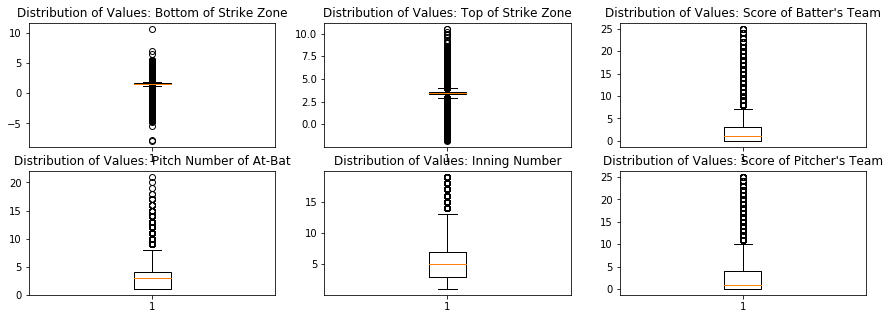

In [2]:
# Statistical check for outliers all columns
for col in list(sit_pitch.columns):
    print("Variable Name: {}".format(col))
    q75, q25 = np.percentile(sit_pitch[col], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1,3,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("Score threshold: {}".format(threshold))
        print("Outlier Count before winsorization: {}".format(
            len((np.where((sit_pitch[col] > max_val) 
                          | (sit_pitch[col] < min_val))[0]))
        ))

# Plot distributions
plt.figure(figsize=(15,5))

plt.subplot(2,3,1)
plt.boxplot(sit_pitch['sz_bot'])
plt.title('Distribution of Values: Bottom of Strike Zone')

plt.subplot(2,3,2)
plt.boxplot(sit_pitch['sz_top'])
plt.title('Distribution of Values: Top of Strike Zone')

plt.subplot(2,3,3)
plt.boxplot(sit_pitch['b_score'])
plt.title("Distribution of Values: Score of Batter's Team")

plt.subplot(2,3,4)
plt.boxplot(sit_pitch['pitch_num'])
plt.title('Distribution of Values: Pitch Number of At-Bat')

plt.subplot(2,3,5)
plt.boxplot(sit_pitch['inning'])
plt.title("Distribution of Values: Inning Number")

plt.subplot(2,3,6)
plt.boxplot(sit_pitch['p_score'])
plt.title("Distribution of Values: Score of Pitcher's Team")
plt.show()

Variable Name: b_count
Score threshold: 1.0
Outlier Count before winsorization: 0
Score threshold: 1.5
Outlier Count before winsorization: 0
Score threshold: 2.0
Outlier Count before winsorization: 0
Score threshold: 2.5
Outlier Count before winsorization: 0
Variable Name: s_count
Score threshold: 1.0
Outlier Count before winsorization: 0
Score threshold: 1.5
Outlier Count before winsorization: 0
Score threshold: 2.0
Outlier Count before winsorization: 0
Score threshold: 2.5
Outlier Count before winsorization: 0
Variable Name: outs
Score threshold: 1.0
Outlier Count before winsorization: 0
Score threshold: 1.5
Outlier Count before winsorization: 0
Score threshold: 2.0
Outlier Count before winsorization: 0
Score threshold: 2.5
Outlier Count before winsorization: 0
Variable Name: on_1b
Score threshold: 1.0
Outlier Count before winsorization: 0
Score threshold: 1.5
Outlier Count before winsorization: 0
Score threshold: 2.0
Outlier Count before winsorization: 0
Score threshold: 2.5
Outlier

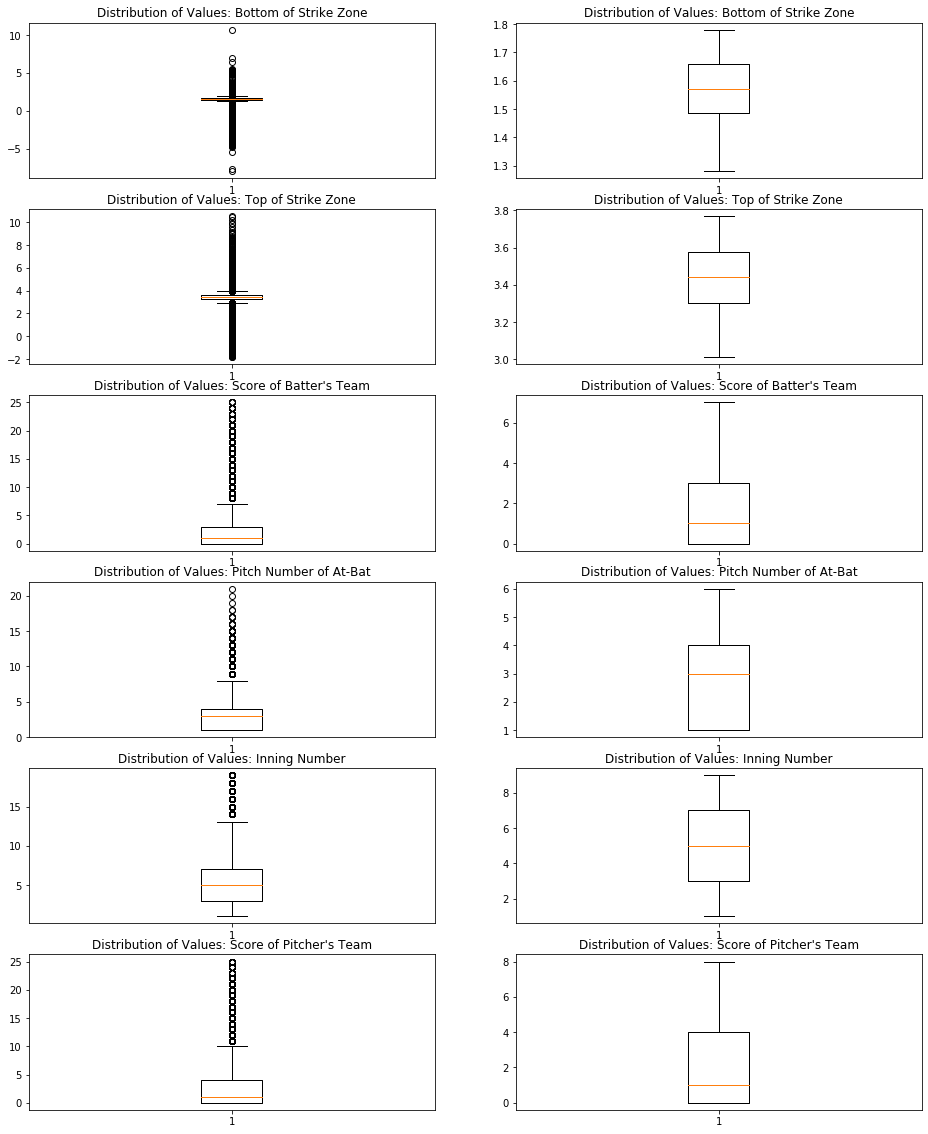

In [3]:
from scipy.stats.mstats import winsorize

# These are treated as continuous, others are treated as categorical
w_1w = ['b_score', 'pitch_num', 'inning', 'p_score']
w_2w = ['sz_bot', 'sz_top']

for col in w_1w:
    sit_pitch['w_' + col] = winsorize(sit_pitch[col], (0,0.05))
    
for col in w_2w:
    sit_pitch['w_' + col] = winsorize(sit_pitch[col], (0.025,0.05))

w_sit_pitch = sit_pitch.drop(['b_score', 'pitch_num', 'inning', 'p_score', 'sz_bot', 'sz_top'], 1)

# Statistical check for outliers after winsorization
for col in list(w_sit_pitch.columns):
    print("Variable Name: {}".format(col))
    q75, q25 = np.percentile(w_sit_pitch[col], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1,3,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("Score threshold: {}".format(threshold))
        print("Outlier Count before winsorization: {}".format(
            len((np.where((w_sit_pitch[col] > max_val) 
                          | (w_sit_pitch[col] < min_val))[0]))
        ))

# Comparison of Distribution Plots Pre- and Post-Winsorization
plt.figure(figsize=(16,20))

plt.subplot(6,2,1)
plt.boxplot(sit_pitch['sz_bot'])
plt.title('Distribution of Values: Bottom of Strike Zone')

plt.subplot(6,2,2)
plt.boxplot(sit_pitch['w_sz_bot'])
plt.title('Distribution of Values: Bottom of Strike Zone')

plt.subplot(6,2,3)
plt.boxplot(sit_pitch['sz_top'])
plt.title('Distribution of Values: Top of Strike Zone')

plt.subplot(6,2,4)
plt.boxplot(sit_pitch['w_sz_top'])
plt.title('Distribution of Values: Top of Strike Zone')

plt.subplot(6,2,5)
plt.boxplot(sit_pitch['b_score'])
plt.title("Distribution of Values: Score of Batter's Team")

plt.subplot(6,2,6)
plt.boxplot(sit_pitch['w_b_score'])
plt.title("Distribution of Values: Score of Batter's Team")

plt.subplot(6,2,7)
plt.boxplot(sit_pitch['pitch_num'])
plt.title('Distribution of Values: Pitch Number of At-Bat')

plt.subplot(6,2,8)
plt.boxplot(sit_pitch['w_pitch_num'])
plt.title('Distribution of Values: Pitch Number of At-Bat')

plt.subplot(6,2,9)
plt.boxplot(sit_pitch['inning'])
plt.title("Distribution of Values: Inning Number")

plt.subplot(6,2,10)
plt.boxplot(sit_pitch['w_inning'])
plt.title("Distribution of Values: Inning Number")

plt.subplot(6,2,11)
plt.boxplot(sit_pitch['p_score'])
plt.title("Distribution of Values: Score of Pitcher's Team")

plt.subplot(6,2,12)
plt.boxplot(sit_pitch['w_p_score'])
plt.title("Distribution of Values: Score of Pitcher's Team")
plt.show()

In [4]:
# Determine relevant features
scor = w_sit_pitch.corr()
cor_target = abs(scor['n_pitch_type'])
relevant_features = cor_target[cor_target>0.01]
print('Relevant Features:\n',relevant_features)

Relevant Features:
 on_1b           0.015862
on_2b           0.026039
on_3b           0.026069
n_pitch_type    1.000000
p_throws_L      0.015629
stand_L         0.066960
w_b_score       0.041604
w_inning        0.060385
w_p_score       0.030439
w_sz_top        0.011316
Name: n_pitch_type, dtype: float64


In [5]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix

# Create dataframe with only relevant features
rel_wsp = w_sit_pitch[list(relevant_features.index)]

# Target pitch type feature
y = rel_wsp['n_pitch_type']
X = rel_wsp.drop('n_pitch_type', 1)

# Certain pitch types are drastically underrepresented, need to oversample data set as a result
ros = RandomOverSampler(random_state=0)
Xrs, yrs = ros.fit_resample(X, y)

# Split to training and test sets
Xrs_train, Xrs_test, yrs_train, yrs_test = train_test_split(Xrs, yrs, test_size=0.25, random_state=400)
print('Training set observations: {}'.format(Xrs_train.shape[0]))
print('Test set observations: {}'.format(Xrs_test.shape[0]))

# Fit based on pitch type
gnb = GaussianNB()
gnb.fit(Xrs_train, yrs_train)
yrs_pred = gnb.predict(Xrs_test)

# Check model
print('Number of mislabeled points out of {}: {}'.format(
    Xrs_test.shape[0], (yrs_test != yrs_pred).sum()))    
print('Accuracy Rate: {}'.format((Xrs_test.shape[0] - (yrs_test != yrs_pred).sum())/Xrs_test.shape[0]))

# Confusion Matrix
confusion_matrix(yrs_test, yrs_pred)

Training set observations: 14461997
Test set observations: 4820666
Number of mislabeled points out of 4820666: 4119812
Accuracy Rate: 0.14538530568182903


array([[     0,      0,      0,      0,      0,      0,      0, 140688,
             0,      0,      0,      0,  84673,      0,  28346,      0,
             0,      0,      0],
       [     0,      0,      0,      0,      0,      0,      0,  56130,
             0,      0,     11,      0, 113354,      0,  83943,      0,
             0,      0,      0],
       [     0,      0,      0,      0,      0,      0,      0,  56752,
             0,      0,     37,      0, 128364,      0,  68994,      0,
             0,      0,      0],
       [     0,      0,      0,      0,      0,      0,      0,  45416,
             0,      0,      0,      0, 195791,      0,  11882,      0,
             0,      0,      0],
       [     0,      0,      0,      0,      0,      0,      0,  84828,
             0,      0,      0,      0,  84903,      0,  84442,      0,
             0,      0,      0],
       [     0,      0,      0,      0,      0,      0,      0,  77205,
             0,      0,     26,      0, 109

In [6]:
# Refit with multinomial NB
mnb = MultinomialNB()
mnb.fit(Xrs_train, yrs_train)
yrs_pred = mnb.predict(Xrs_test)

# Check model accuracy
print('Number of mislabeled points out of {}: {}'.format(
    Xrs_test.shape[0], (yrs_test != yrs_pred).sum()))    
print('Accuracy Rate: {}'.format((Xrs_test.shape[0] - (yrs_test != yrs_pred).sum())/Xrs_test.shape[0]))

# Print confusion Matrix
confusion_matrix(yrs_test, yrs_pred)

Number of mislabeled points out of 4820666: 3855744
Accuracy Rate: 0.2001636288429856


array([[ 28389,      0,      0,      0,  56387,  28230,      0,  28082,
             0,      0,  84333,      0,  28286,      0,      0,      0,
             0,      0,      0],
       [ 14849,    708,      0,  26553,  32115,   2138,      0,  36656,
          2409,   1436,  10475,   1743,  21060,  19430,  49683,  19769,
          2245,  10956,   1213],
       [ 18045,   1550,      0,  28385,  34915,   1821,      0,  39895,
          1680,   1207,  12069,   2757,  25878,  19545,  34509,  15557,
          1435,  13611,   1288],
       [ 23243,      0,      0,  53160,  42442,   2826,      0,  36395,
          2812,      0,  11758,   2192,  33652,  22063,   7809,   2816,
           287,  10364,   1270],
       [ 28258,      0,      0,      0, 113089,      0,      0,  56570,
             0,      0,      0,      0,      0,      0,  56256,      0,
             0,      0,      0],
       [ 21635,   1234,      0,  22419,  25108,   2306,      0,  48313,
          1939,   1370,  10829,   3128,  26

In [7]:
# Create lookup for pitch type
pt_lookup = dict(zip(num.classes_, num.transform(num.classes_)))
print(pt_lookup)

# Create crosstab between target and highest correlation features
p_stance_inning_table = pd.crosstab(rel_wsp['n_pitch_type'], rel_wsp['w_inning'])
p_stance_inning_table

{'AB': 0, 'CH': 1, 'CU': 2, 'EP': 3, 'FA': 4, 'FC': 5, 'FF': 6, 'FO': 7, 'FS': 8, 'FT': 9, 'IN': 10, 'KC': 11, 'KN': 12, 'PO': 13, 'SC': 14, 'SI': 15, 'SL': 16, 'UN': 17, 'nan': 18}


w_inning,1,2,3,4,5,6,7,8,9
n_pitch_type,,,,,,,,,
0,0,0,2,1,0,1,2,1,2
1,31326,33105,37877,39800,38015,35134,28449,25440,23643
2,24206,27710,30179,31502,30127,28913,24741,21606,15407
3,65,109,119,152,136,141,77,11,5
4,3,0,3,0,0,0,0,1,2
5,15694,15899,16178,17085,16733,16569,16273,16603,18722
6,130255,112276,105670,100371,101113,106450,117606,123574,117562
7,0,0,3,20,21,79,224,328,135
8,4581,4625,4853,4980,4834,4831,4927,5122,4952


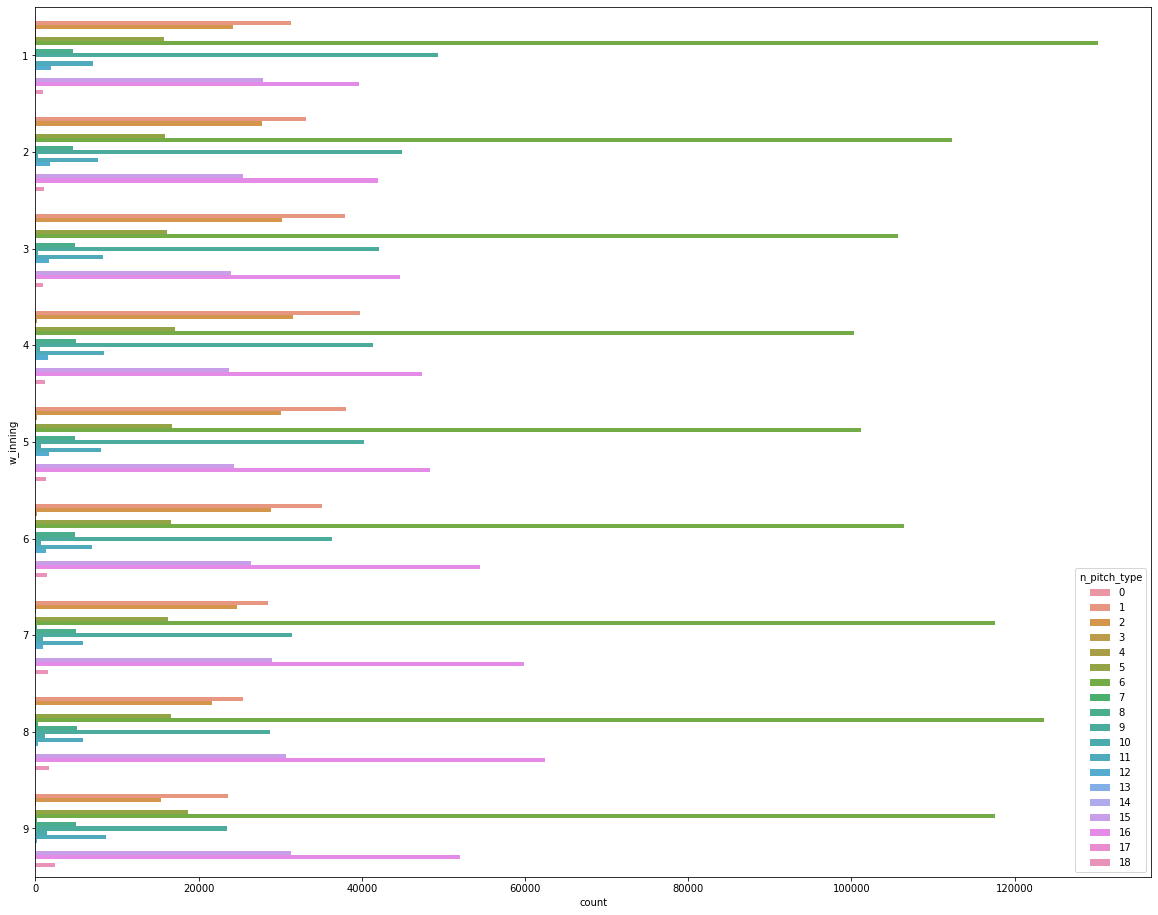

In [8]:
# Visualize Crosstab
plt.figure(figsize=(20,16))
sns.countplot(y='w_inning', hue='n_pitch_type', data=rel_wsp)
plt.show()

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Create sample dataset to limit processing time
sample_wsp = rel_wsp.sample(frac=.025, replace=True, random_state=400)

# Target pitch type, using the two highest correlation variables
nbrs = KNeighborsClassifier(n_neighbors=10)
X = sample_wsp[['w_b_score', 'w_inning']]
y = sample_wsp['n_pitch_type']
print('done1')
Xrs, yrs = ros.fit_resample(X, y)
print('done2')
Xrs_train, Xrs_test, yrs_train, yrs_test = train_test_split(Xrs, yrs, test_size=0.25, random_state=400)
print('done3')
nbrs.fit(Xrs_train, yrs_train)
print('done4')
yrs_pred = nbrs.predict(Xrs_test)
print('done5')
print('Accuracy: {}'.format((Xrs_test.shape[0] - (yrs_test != yrs_pred).sum())/Xrs_test.shape[0]))

done1
done2
done3
done4
done5
Accuracy: 0.22993920548174768


[0.11670864 0.13476315 0.13135025 0.13173297 0.1573528  0.13512876
 0.14409534 0.1226141  0.1476523  0.1059223 ]


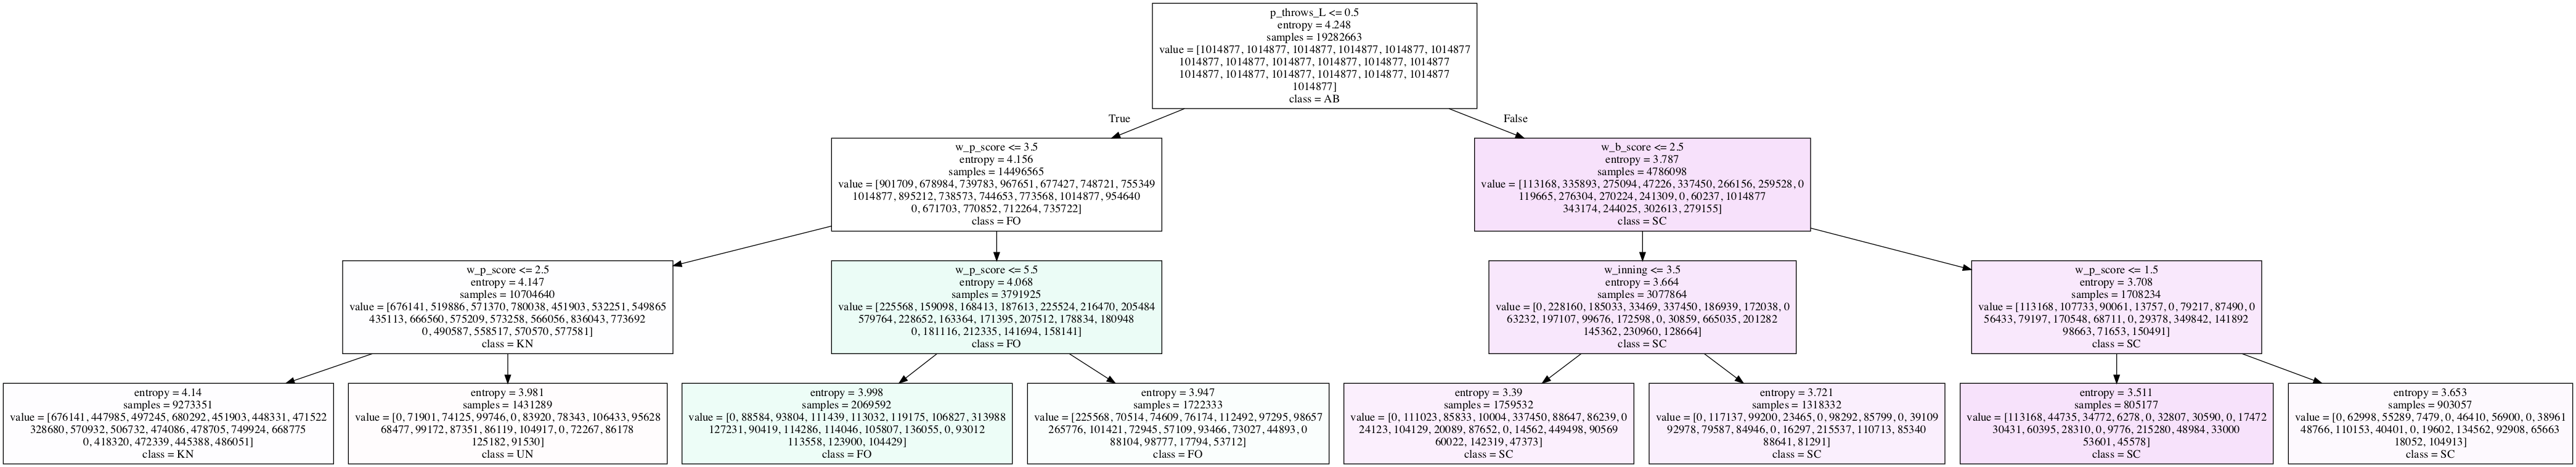

In [11]:
# Decision tree model
from sklearn import tree
from IPython.display import Image
import pydotplus, graphviz
from sklearn.model_selection import cross_val_score

# Reset features and target
X = rel_wsp.drop('n_pitch_type', 1)
y = rel_wsp['n_pitch_type']
X_rs, y_rs = ros.fit_resample(X,y)

# Using a simple decision tree to determine fastball or offspeed
pitch_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3,
)
pitch_tree.fit(X_rs, y_rs)

dot_data = tree.export_graphviz(
    pitch_tree, out_file=None,
    feature_names=X.columns,
    class_names=['AB', 'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN', 
                 'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'UN', 'nan'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
print(cross_val_score(pitch_tree, X_rs, y_rs, cv=10))
Image(graph.create_png())
# Tree appears less accurate than simple NB

In [12]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_rs, y_rs, cv=10)

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

array([0.7350462 , 0.78033908, 0.81337125, 0.80035389, 0.79646492,
       0.79892671, 0.80163742, 0.80155716, 0.8020322 , 0.80062212])